## MODEL SVR

Files originals: 1278, files després de dropna: 1278 (s'han eliminat 0 files).

Comprovació NaNs per columna:
Open           0
High           0
Low            0
Volume         0
EMA_7          0
EMA_40         0
MACD           0
Signal_Line    0
MACD_Hist      0
RSI            0
ATR            0
Close          0
dtype: int64

Rangs de dates:
  Train: 2020-01-02 → 2023-07-21 (894 samples)
  Val:   2023-07-24 → 2024-04-24 (191 samples)
  Test:  2024-04-25 → 2025-01-31 (193 samples)

Cap NaN trobat als subconjunts de train/val/test després del dropna.

Escalat completat sense problemes de NaNs o Inf.
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Millors hiperparàmetres trobats amb GridSearchCV (només TRAIN):
{'C': 100, 'epsilon': 0.01, 'gamma': 0.001}

VALIDATION → SVR RBF: MSE: 0.3829, MAE: 0.4572, R²: 0.9989
TEST       → SVR RBF: MSE: 4.9510, MAE: 1.5697, R²: 0.9860


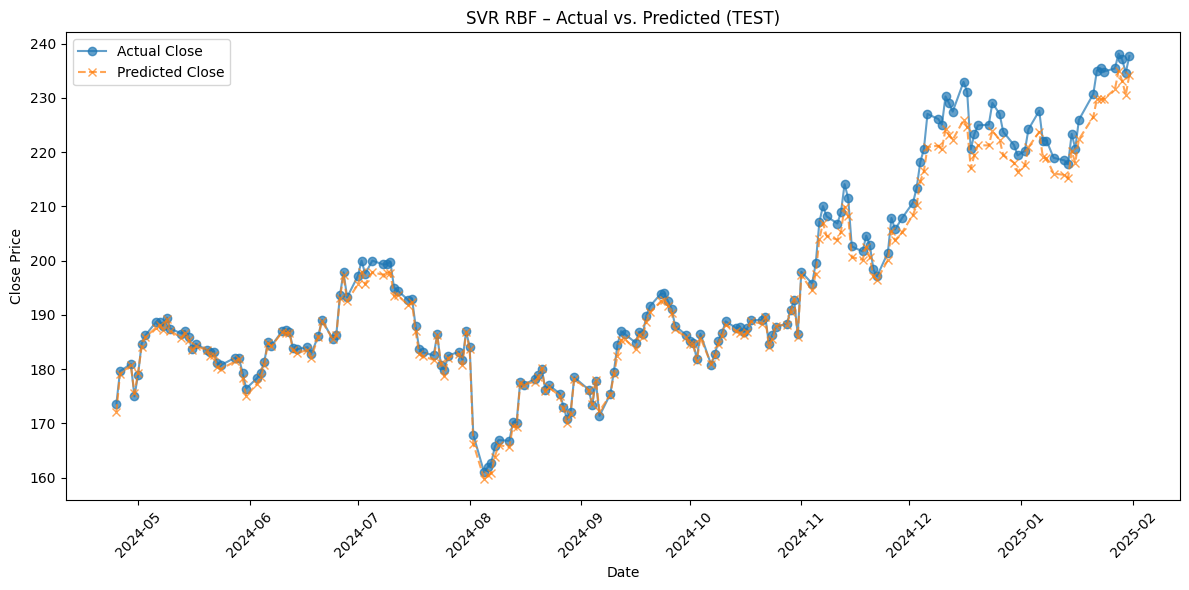

In [ ]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# Ruta al CSV (canvia-la segons el teu entorn)
BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
file_name = "Amazon_Stock_Price_output.csv"
file_path = os.path.join(BASE_PATH, file_name)

# Llegim el CSV
df = pd.read_csv(file_path)

# Convertim 'Date' a datetime i ordenem cronològicament
#df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
#df.sort_values('Date', inplace=True)

# Definim quines columnes són les característiques (features) i la target
features = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
]
target = 'Close'

# Eliminem files amb NaNs a qualsevol feature o a la target
before_drop = len(df)
df.dropna(subset=features + [target], inplace=True)
after_drop = len(df)
print(f"Files originals: {before_drop}, files després de dropna: {after_drop} (s'han eliminat {before_drop - after_drop} files).")

# Reinicialitzem l'índex per evitar forats en el split posterior
df.reset_index(drop=True, inplace=True)

# Mostrem un resum de les columnes i verificació de NaNs
print("\nComprovació NaNs per columna:")
print(df[features + [target]].isna().sum())

# Split cronològic: train/val/test
n_total = len(df)
train_size = int(n_total * 0.70)
val_size   = int(n_total * 0.15)
test_size  = n_total - train_size - val_size

# Extraiem X_raw i y_raw ja ordenats (aprofitem que df està ordenat)
X_raw = df[features].values
y_raw = df[target].values

# Dividim en subconjunts de manera cronològica
X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]

X_val_raw   = X_raw[train_size:train_size + val_size]
y_val_raw   = y_raw[train_size:train_size + val_size]

X_test_raw  = X_raw[train_size + val_size:]
y_test_raw  = y_raw[train_size + val_size:]

# Verifiquem els rangs de dates de cada subconjunt
dates = df['Date']
date_train_start = dates.iloc[0]
date_train_end   = dates.iloc[train_size - 1]

date_val_start = dates.iloc[train_size]
date_val_end   = dates.iloc[train_size + val_size - 1]

date_test_start = dates.iloc[train_size + val_size]
date_test_end   = dates.iloc[-1]

print(f"\nRangs de dates:")
print(f"  Train: {date_train_start.date()} → {date_train_end.date()} ({len(X_train_raw)} samples)")
print(f"  Val:   {date_val_start.date()} → {date_val_end.date()} ({len(X_val_raw)} samples)")
print(f"  Test:  {date_test_start.date()} → {date_test_end.date()} ({len(X_test_raw)} samples)")

# Assercions per assegurar-nos que no hi ha NaNs després del split
assert not np.isnan(X_train_raw).any(), "Hi ha NaNs a X_train_raw!"
assert not np.isnan(y_train_raw).any(), "Hi ha NaNs a y_train_raw!"
assert not np.isnan(X_val_raw).any(),   "Hi ha NaNs a X_val_raw!"
assert not np.isnan(y_val_raw).any(),   "Hi ha NaNs a y_val_raw!"
assert not np.isnan(X_test_raw).any(),  "Hi ha NaNs a X_test_raw!"
assert not np.isnan(y_test_raw).any(),  "Hi ha NaNs a y_test_raw!"
print("\nCap NaN trobat als subconjunts de train/val/test després del dropna.")


# Escalem X amb StandardScaler (només amb X_train_raw)
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

# Comprovem que l'escala no produeix NaNs ni Inf
assert not np.isnan(X_train).any() and not np.isinf(X_train).any(), "NaN/Inf a X_train escalat!"
assert not np.isnan(X_val).any()   and not np.isinf(X_val).any(),   "NaN/Inf a X_val escalat!"
assert not np.isnan(X_test).any()  and not np.isinf(X_test).any(),  "NaN/Inf a X_test escalat!"

# Escalem y amb StandardScaler (només amb y_train_raw)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
y_val   = scaler_y.transform(y_val_raw.reshape(-1, 1)).ravel()
y_test  = scaler_y.transform(y_test_raw.reshape(-1, 1)).ravel()

# Comprovem que no es generen NaNs ni Inf en y escalat
assert not np.isnan(y_train).any() and not np.isinf(y_train).any(), "NaN/Inf a y_train escalat!"
assert not np.isnan(y_val).any()   and not np.isinf(y_val).any(),   "NaN/Inf a y_val escalat!"
assert not np.isnan(y_test).any()  and not np.isinf(y_test).any(),  "NaN/Inf a y_test escalat!"

print("\nEscalat completat sense problemes de NaNs o Inf.")

# Cerca de hiperparàmetres amb TimeSeriesSplit CV
svr = SVR(kernel='rbf')
param_grid = {
    'C':       [1, 10, 100, 1000],
    'gamma':   [0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1]
}

# Utilitzem TimeSeriesSplit només sobre l'entrenament
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print("\nMillors hiperparàmetres trobats amb GridSearchCV (només TRAIN):")
print(best_params)


# Entrenament final i avaluació sobre Val i Test

# Re-entrenem SVR amb els millors paràmetres sobre TOT l'entrenament
best_svr = SVR(
    kernel='rbf',
    C=best_params['C'],
    gamma=best_params['gamma'],
    epsilon=best_params['epsilon']
)
best_svr.fit(X_train, y_train)

# Avaluació sobre VALIDATION
y_val_pred_scaled = best_svr.predict(X_val)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()
y_val_true = y_val_raw  # ja està en escala original

rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
mae_val = mean_absolute_error(y_val_true, y_val_pred)
r2_val  = r2_score(y_val_true, y_val_pred)

print(f"\nVALIDATION → SVR RBF: RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")

# Avaluació sobre TEST
y_test_pred_scaled = best_svr.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_test_true = y_test_raw  # ja està en escala original

rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test  = r2_score(y_test_true, y_test_pred)

print(f"TEST       → SVR RBF: RMSE: {rmse:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# Plot actual vs. predicted al TEST set
dates_test = df['Date'].iloc[train_size + val_size:].values

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_true, label='Actual Close', linestyle='-', marker='o', alpha=0.7)
plt.plot(dates_test, y_test_pred, label='Predicted Close', linestyle='--', marker='x', alpha=0.7)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SVR RBF – Actual vs. Predicted (TEST)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import plotly.graph_objects as go
import matplotlib.pyplot as plt  

def recompute_indicators(df):

    # EMA 7 i EMA 40
    df['EMA_7']  = df['Close'].ewm(span=7, adjust=False).mean()
    df['EMA_40'] = df['Close'].ewm(span=40, adjust=False).mean()

    # MACD (EMA_12 - EMA_26), Signal Line (EMA de MACD), MACD Hist
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['Signal_Line']

    # RSI (Relative Strength Index) de 14 períodes
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=14, min_periods=14).mean()
    avg_loss = loss.rolling(window=14, min_periods=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # ATR (Average True Range) de 14 períodes
    high_low = df['High'] - df['Low']
    high_prev_close = (df['High'] - df['Close'].shift(1)).abs()
    low_prev_close  = (df['Low'] - df['Close'].shift(1)).abs()
    true_range = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(window=14, min_periods=14).mean()

    # Algunes de les primeres files quedaran NaN perquè no hi ha prou dada per al càlcul.
    return


BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
file_name = "Amazon_Stock_Price_output.csv"
file_path = os.path.join(BASE_PATH, file_name)

# Llegim el CSV
df = pd.read_csv(file_path)

# Convertim 'Date' a datetime i ordenem cronològicament
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Recalculem indicadors inicials per assegurar-nos que tinguem les columnes d'indicadors
recompute_indicators(df)

# Definim quines columnes són les característiques (features) i la target
FEATURE_COLUMNS = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
]
TARGET_COLUMN = 'Close'

# Eliminem files amb NaNs a qualsevol feature o a la target
before_drop = len(df)
df.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN], inplace=True)
after_drop = len(df)
print(f"Files originals: {before_drop}, files després de dropna: {after_drop} (s'han eliminat {before_drop - after_drop} files).")

# Reinicialitzem l'índex per evitar forats en el split posterior
df.reset_index(drop=True, inplace=True)

# Mostrem un petit resum de NaNs (per comprovar)
print("\nComprovació NaNs per columna després de dropna:")
print(df[FEATURE_COLUMNS + [TARGET_COLUMN]].isna().sum())

#Split cronològic: train / val / test

n_total = len(df)
train_size = int(n_total * 0.70)
val_size   = int(n_total * 0.15)
test_size  = n_total - train_size - val_size

# Extraiem X_raw i y_raw ja ordenats
X_raw = df[FEATURE_COLUMNS].values
y_raw = df[TARGET_COLUMN].values

# Dividim en subconjunts de manera cronològica
X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]

X_val_raw   = X_raw[train_size : train_size + val_size]
y_val_raw   = y_raw[train_size : train_size + val_size]

X_test_raw  = X_raw[train_size + val_size :]
y_test_raw  = y_raw[train_size + val_size :]

# Verifiquem els rangs de dates de cada subconjunt
dates = df['Date']
date_train_start = dates.iloc[0]
date_train_end   = dates.iloc[train_size - 1]

date_val_start = dates.iloc[train_size]
date_val_end   = dates.iloc[train_size + val_size - 1]

date_test_start = dates.iloc[train_size + val_size]
date_test_end   = dates.iloc[-1]

print(f"\nRangs de dates:")
print(f"  Train: {date_train_start.date()} → {date_train_end.date()}  ({len(X_train_raw)} samples)")
print(f"  Val:   {date_val_start.date()} → {date_val_end.date()}  ({len(X_val_raw)} samples)")
print(f"  Test:  {date_test_start.date()} → {date_test_end.date()}  ({len(X_test_raw)} samples)")

# Assercions per assegurar-nos que no hi ha NaNs després del split
assert not np.isnan(X_train_raw).any(), "Hi ha NaNs a X_train_raw!"
assert not np.isnan(y_train_raw).any(), "Hi ha NaNs a y_train_raw!"
assert not np.isnan(X_val_raw).any(),   "Hi ha NaNs a X_val_raw!"
assert not np.isnan(y_val_raw).any(),   "Hi ha NaNs a y_val_raw!"
assert not np.isnan(X_test_raw).any(),  "Hi ha NaNs a X_test_raw!"
assert not np.isnan(y_test_raw).any(),  "Hi ha NaNs a y_test_raw!"
print("\nCap NaN trobat als subconjunts de train/val/test després del dropna.")

# Escalat de característiques (X) i variable objectiu (y)
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

assert not np.isnan(X_train).any() and not np.isinf(X_train).any(), "NaN/Inf a X_train escalat!"
assert not np.isnan(X_val).any()   and not np.isinf(X_val).any(),   "NaN/Inf a X_val escalat!"
assert not np.isnan(X_test).any()  and not np.isinf(X_test).any(),  "NaN/Inf a X_test escalat!"

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
y_val   = scaler_y.transform(y_val_raw.reshape(-1, 1)).ravel()
y_test  = scaler_y.transform(y_test_raw.reshape(-1, 1)).ravel()

assert not np.isnan(y_train).any() and not np.isinf(y_train).any(), "NaN/Inf a y_train escalat!"
assert not np.isnan(y_val).any()   and not np.isinf(y_val).any(),   "NaN/Inf a y_val escalat!"
assert not np.isnan(y_test).any()  and not np.isinf(y_test).any(),  "NaN/Inf a y_test escalat!"

print("\nEscalat completat sense problemes de NaNs o Inf.")

# Cerca de hiperparàmetres amb TimeSeriesSplit
svr = SVR(kernel='rbf')
param_grid = {
    'C':       [1, 10, 100, 1000],
    'gamma':   [0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print("\nMillors hiperparàmetres trobats amb GridSearchCV (només TRAIN):")
print(best_params)

# Entrenament final amb els millors paràmetres
best_svr = SVR(
    kernel='rbf',
    C=best_params['C'],
    gamma=best_params['gamma'],
    epsilon=best_params['epsilon']
)
best_svr.fit(X_train, y_train)

# Avaluació sobre VALIDATION (desescalem)
y_val_pred_scaled = best_svr.predict(X_val)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()
y_val_true = y_val_raw  # ja en escala original

rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
mae_val = mean_absolute_error(y_val_true, y_val_pred)
r2_val  = r2_score(y_val_true, y_val_pred)

print(f"\nVALIDATION → SVR RBF: RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")

# Avaluació sobre TEST (desescalem)
y_test_pred_scaled = best_svr.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_test_true = y_test_raw  # ja en escala original

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test  = r2_score(y_test_true, y_test_pred)

print(f"TEST       → SVR RBF: MSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# Creació carpeta de resultats
# Directori base on guardarem tot
results_base = "resultats_SVR"
model_folder = os.path.join(results_base, "amazon")

os.makedirs(model_folder, exist_ok=True)
print(f"\nCarpeta de resultats creada a: {model_folder}")
dataset_name ='Amazon'

# Guardar mètriques en un CSV
metrics = pd.DataFrame({
        "Dataset": [dataset_name],
        "MAE":     [mae_test],
        "RMSE":    [rmse_test],
        "R2":      [r2_test]
    })
df_metrics = pd.DataFrame(metrics)
metrics_csv = os.path.join(model_folder, "metrics_summary.csv")
df_metrics.to_csv(metrics_csv, index=False)
print(f"  ✓ Mètriques guardades a: {metrics_csv}")


# Graficar Real vs Predicho (Test) amb Plotly i guardar html

dates_test = df['Date'].iloc[train_size + val_size :].reset_index(drop=True)
dataset_name = "amazon"

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=dates_test,
    y=y_test_true,
    mode='lines',
    name='Real (Close)',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=dates_test,
    y=y_test_pred,
    mode='lines',
    name='Predicho',
    line=dict(color='red', dash='dash')
))
fig.update_layout(
    title=f"{dataset_name.capitalize()} – Real vs Predicción (Test)",
    xaxis_title='Fecha',
    yaxis_title='Precio Close (USD)',
    template='plotly_white',
    xaxis_rangeslider_visible=True
)

plot_html = os.path.join(model_folder, f"{dataset_name}_test_plot.html")
fig.write_html(plot_html)
print(f"  ✓ Gràfica Test guardada en: {plot_html}")

# Predicció autoregressiva per als propers 10 dies laborables

df_future = df.copy().reset_index(drop=True)
future_dates = pd.bdate_range(
    start=df_future['Date'].iloc[-1] + pd.Timedelta(days=1),
    periods=10
)
future_preds = []

for date in future_dates:
    # Última fila amb indicadors complets
    last_row = df_future.iloc[-1]
    feature_values = last_row[FEATURE_COLUMNS].values.reshape(1, -1)

    # Escalar i predir
    feature_scaled = scaler_X.transform(feature_values)
    y_pred_scaled = best_svr.predict(feature_scaled)[0]
    y_pred_real   = scaler_y.inverse_transform([[y_pred_scaled]])[0][0]
    future_preds.append(y_pred_real)

    # Afegir nova fila a df_future amb loc
    prev = df_future.iloc[-1]
    new_index = len(df_future)
    df_future.loc[new_index, 'Date']        = date
    df_future.loc[new_index, 'Open']        = prev['Close']
    df_future.loc[new_index, 'High']        = y_pred_real
    df_future.loc[new_index, 'Low']         = y_pred_real
    df_future.loc[new_index, 'Close']       = y_pred_real
    df_future.loc[new_index, 'Volume']      = prev['Volume']
    # Indicadors tècnics fins a recalcular
    df_future.loc[new_index, 'EMA_7']       = np.nan
    df_future.loc[new_index, 'EMA_40']      = np.nan
    df_future.loc[new_index, 'MACD']        = np.nan
    df_future.loc[new_index, 'Signal_Line'] = np.nan
    df_future.loc[new_index, 'MACD_Hist']   = np.nan
    df_future.loc[new_index, 'RSI']         = np.nan
    df_future.loc[new_index, 'ATR']         = np.nan

    # Recalcular indicadors en tot el DataFrame
    recompute_indicators(df_future)

# Guardar prediccions futures en un CSV
df_fut_pred = pd.DataFrame({
    "Date":           future_dates,
    "Predicted_Close": future_preds
})
fut_csv = os.path.join(model_folder, f"{dataset_name}_future_10days.csv")
df_fut_pred.to_csv(fut_csv, index=False)
print(f"  ✓ Prediccions futures guardades en: {fut_csv}")

# Graficar històric + prediccions futures amb Plotly

fig_future = go.Figure()
fig_future.add_trace(go.Scatter(
    x=df['Date'], y=df['Close'],
    mode='lines', name='Histórico Close', line=dict(color='lightblue')
))
fig_future.add_trace(go.Scatter(
    x=future_dates, y=np.array(future_preds),
    mode='lines+markers', name='Predicción futura',
    line=dict(color='orange', dash='dash'),
    marker=dict(size=6)
))
fig_future.update_layout(
    title=f"{dataset_name.capitalize()} – Predicción Próximos 10 Días",
    xaxis_title='Fecha',
    yaxis_title='Precio Close (USD)',
    template='plotly_white',
    xaxis_rangeslider_visible=True
)

fut_html = os.path.join(model_folder, f"{dataset_name}_future_plot.html")
fig_future.write_html(fut_html)
print(f"  ✓ Gràfica futura guardada en: {fut_html}")

Files originals: 1278, files després de dropna: 1265 (s'han eliminat 13 files).

Comprovació NaNs per columna després de dropna:
Open           0
High           0
Low            0
Volume         0
EMA_7          0
EMA_40         0
MACD           0
Signal_Line    0
MACD_Hist      0
RSI            0
ATR            0
Close          0
dtype: int64

Rangs de dates:
  Train: 2020-01-22 → 2023-07-27  (885 samples)
  Val:   2023-07-28 → 2024-04-26  (189 samples)
  Test:  2024-04-29 → 2025-01-31  (191 samples)

Cap NaN trobat als subconjunts de train/val/test després del dropna.

Escalat completat sense problemes de NaNs o Inf.
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Millors hiperparàmetres trobats amb GridSearchCV (només TRAIN):
{'C': 1000, 'epsilon': 0.01, 'gamma': 0.001}

VALIDATION → SVR RBF: MSE: 0.6528, MAE: 0.6378, R²: 0.9981
TEST       → SVR RBF: MSE: 4.1463, MAE: 1.5237, R²: 0.9882

Carpeta de resultats creada a: resultats_SVR\amazon
  ✓ Mètriques guardades a: re